In [1]:
from parameter_object import parameterClass
%pylab inline
#Imports .mdf files for providing ground-truth data.
from sklearn.cross_validation import ShuffleSplit
import numpy as np
#sys.path.append('resources')
#sys.path.append('final_software')
import v2_functions as v2
reload(v2)
from scipy.ndimage import measurements, center_of_mass,filters
from sklearn.ensemble import ExtraTreesRegressor
import time
import tifffile as tif_fn
import csv
import numpy as np
import cPickle as pickle
def read_ground_truth(file_name,time_pt):
    with open(str(file_name),'r') as f:
        txt = f.readlines()
    track ={}
    temp_x = []
    temp_y = [];
    temp_z = [];
    name = []
    #Populates new array if line is 'Track', and adds points if labelled 'Point'
    for i in range(0,txt.__len__()):
        line = txt[i].split(' ')
        if line[0] == 'Track':
            name.append(line[1])
            if temp_x.__len__() >0:
                track[int(name[-2])] = [temp_x, temp_y, temp_z]
            temp_x = [];
            temp_y = [];
            temp_z = [];

        elif line[0] == 'Point':        
            temp_x.append(float(line[2]))
            temp_y.append(float(line[3]))
            temp_z.append(float(line[5]))
    
    
    if temp_x.__len__() >0:
        track[int(name[-1])] = [temp_x, temp_y, temp_z]
    
    #Empty array.
    lengths = []
    dots = []
    for t in track:
        lengths.append(track[t][0].__len__())
    
    #Finds the median point on the label.
    average_height = np.median(np.array(lengths))
    center_pt = int((average_height-1)/2)
    
    #Find the rectangles of interest.
    rects = (time_pt, int(0), int(0), int(abs(par_obj.width)), int(abs(par_obj.height)))

    #accepts and calculates track centers from tracks which are at least larger than half the median.
    track_center = []
    for t in track:
        x = track[t][0]
        y = track[t][1]
        z = track[t][2]
        if x.__len__() > center_pt:
            #Always calculates the track center.
            cent_x = x[int(round(x.__len__()/2,0))]
            cent_y = y[int(round(x.__len__()/2,0))]
            cent_z = z[int(round(x.__len__()/2,0))]
        track_center.append([cent_y,cent_x,cent_z])

    return track_center

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/trackpy/utils.py:46: UserWarning: Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot be used. For better linking performance, upgrade or downgrade scipy.
  warnings.warn("Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot "


In [24]:

#This is a class and function which takes over the print output in the absence of the gui.
class intObject():
    def __init__(self):
        self.pa = None
    def report_progress(self,string):
        d=0
        print(string)
        
    
#Here we choose which of our experiments to run.

for experiment in [1]:
    

    
    if experiment == 1:
        path = '/Users/martin/Pictures/Live_mdf/'
        tif_out_path = '/Users/martin/Pictures/Live_mdf/out'

    #we open the csv file for writing and write header line
    csvPath = path+"out/";
    output= ['TP',
            'FP',
             'FN',
             'time_pt',
             'rel_thr',
             'training',
             'file_no']
    with open(csvPath+'outputData.csv', 'wb') as csvfile:
        spamwriter = csv.writer(csvfile,  dialect='excel')
        spamwriter.writerow(output)

    #This is where we have the parameter sets.
    par_obj = parameterClass()
    par_obj.TP={}
    par_obj.FP={}
    par_obj.FN={}

    for training in range(0,30,5):
        par_obj.sigma =  float(training);
        par_obj.min_distance=[par_obj.sigma,par_obj.sigma,par_obj.sigma/5]
        #par_obj.num_of_tree = training
        par_obj.TP[training]={}
        par_obj.FP[training]={}
        par_obj.FN[training]={}
        
        #Number of times to repeat.
        for bc in range(0,1):
            #reset array of memmaps

            
            int_obj = intObject()
            
            
            ####If we have cross-validation.
            #if experiment==1:
            #    ss = ShuffleSplit(30, n_iter=1, test_size=15, train_size=num_of_train)
            #for train_index, test_index in ss:
                 #print("%s %s" % (train_index, test_index))
            ####
            ###Remove the following in favour of the above cross-validation
            train_index = [0]
            test_index = [0]
            ###
    
            temp_index = list(train_index)
            #temp_index.extend(list(test_index))
            #test_index = temp_index
            print train_index, test_index

            int_obj = intObject()
            par_obj.gt_sum = {}
            par_obj.gt_dense ={}
            par_obj.f_matrix =[]
            par_obj.o_patches=[]
            par_obj.gt_sum = {}
            par_obj.gt_dense ={}
            par_obj.gt_file_array = []
            par_obj.frames_2_load = {}
            par_obj.gt_array =[]
            
            
            #####
            #####
            ####May want to change these of course for the hessian and maxima finding.
            par_obj.z_calibration=3
            
            par_obj.abs_thr=0
            par_obj.rel_thr=0
            par_obj.max_features = 52
            par_obj.num_of_tree = 36
            ####
            #####
            ######
            
            par_obj.feature_type = 'fine3'

            if experiment== 1:
                
                nstr = [0]*1#Number of files to upload
            
            
            datasets=['dense_arr','feat_arr','double_feat_arr','pred_arr','sum_pred','maxi_arr','pts','roi_stk_x','roi_stk_y','roi_stkint_x','roi_stkint_y']
            par_obj.data_store={}
            
            for dataname in datasets:
                par_obj.data_store[dataname]={}

            #We initalize each of our images in our experiments.
            for i in range(0,nstr.__len__()):
                
                n = str(i).zfill(3)
                if experiment== 1:
                    par_obj.ch_active =[0,1]
                    
                    pixel_cut_off_3D = 15.0
                    #par_obj.limit_time_pt = 10 #########HERE IS TO BE DELETED
                    
                    #i =0 is the first datafile. To add more do i==1 etc.
                    if i == 0:
                        ##############
                        ############## These are the parameters of our first datafile.
                        ##############
                        
                        #Input image.
                        file_str = path+'/Concatenated Stacks_resized-1_every10.tif'
                        #User training.
                        #ROI_str = path+'/Concatenated Stacks_resized-1_every10_2.quantiROI'
                        #ROI_str = path+'/NBtraining'+str(21)+'.quantiROI'
                        #ROI_str = path+'/NBtraining21_withNeg.quantiROI'
                        ROI_str = path+'/NBtraining_first_and_last.quantiROI'
                        #or
                        #MDF=True
                        #The ground-truth. Indexed by time-point.
                        gt_time_pt = {}
                        gt_time_pt[0]  = path+'Concatenated Stacks_resized-1_every10.tif.mdf'
                        gt_time_pt[1]  = path+'Concatenated Stacks_resized-1_every10.tif2.mdf'
                        gt_time_pt[2]  = path+'Concatenated Stacks_resized-1_every10.tif3.mdf'
                        gt_time_pt[3]  = path+'Concatenated Stacks_resized-1_every10.tif4.mdf'
                        gt_time_pt[4]  = path+'Concatenated Stacks_resized-1_every10.tif5.mdf'
                        gt_time_pt[5]  = path+'Concatenated Stacks_resized-1_every10.tif6.mdf'
                        gt_time_pt[6]  = path+'Concatenated Stacks_resized-1_every10.tif7.mdf'
                        gt_time_pt[7]  = path+'Concatenated Stacks_resized-1_every10.tif8.mdf'
                        gt_time_pt[8]  = path+'Concatenated Stacks_resized-1_every10.tif9.mdf'
                        gt_time_pt[9]  = path+'Concatenated Stacks_resized-1_every10.tif10.mdf'
                        gt_time_pt[10] = path+'Concatenated Stacks_resized-1_every10.tif11.mdf'
                        gt_time_pt[11] = path+'Concatenated Stacks_resized-1_every10.tif12.mdf'
                        gt_time_pt[12] = path+'Concatenated Stacks_resized-1_every10.tif13.mdf'
                        gt_time_pt[13] = path+'Concatenated Stacks_resized-1_every10.tif14.mdf'
                        gt_time_pt[14] = path+'Concatenated Stacks_resized-1_every10.tif15.mdf'
                        
                        par_obj.file_array.append(file_str)
                        par_obj.gt_array.append(gt_time_pt)
                

            #Gets the dimensional information from the first file.
            #Assumes they are all the same. May not be true, but Martin you changed the data_structure :-).
            v2.import_data_fn(par_obj,[par_obj.file_array[0]])
            try:
                time_list = np.arange(0,par_obj.limit_time_pt)
                par_obj.max_t = par_obj.limit_time_pt
            except:
                time_list = np.arange(0,par_obj.max_t+1)
            
            par_obj.tpt_list = np.arange(0,par_obj.max_t+1)
            par_obj.max_file = nstr.__len__()
            
            
            
            par_obj.initiate_data_store()
            

            ########################
            ########################
            ########################
           
            
            
            print('Calculating features')
            neg_regions=[]
            neg_dots=[]
            pos_regions=[]
            pos_dots=[]
            
            #Import ROI for file.
            with open(ROI_str,"rb") as ROI:
                ROI_file = pickle.load(ROI)
                par_obj.saved_dots = ROI_file['dots']
                par_obj.saved_ROI = ROI_file['rect']
            no_regions = len(par_obj.saved_ROI)
            
            #separate positive and negative training examples
            for roi,dots in zip(par_obj.saved_ROI,par_obj.saved_dots):
                if dots==[]: #if no dots in ROI, then consider part of 'negative training set'
                    neg_regions.append(roi)
                    neg_dots.append(dots)
                else: #positive training examples
                    pos_regions.append(roi)
                    pos_dots.append(dots)
            #always include neg trainig examples
            regions=neg_regions
            dots=neg_dots
            
            
            #uncomment for changing amount of training
            '''#sanity checks
            pos_len = len(pos_regions)
            assert pos_len>=training
            assert pos_len==len(pos_dots)
            
            #randomly subsample training set
            indexes=numpy.random.choice(np.arange(0,pos_len),size=training,replace=False)
            '''
            indexes=np.arange(0,pos_len)
            for idx in range(pos_len):
                if idx in indexes:
                    regions.append(pos_regions[idx])
                    dots.append(pos_dots[idx])
                else:
                    pass
            
            par_obj.saved_ROI=regions
            par_obj.saved_dots=dots
            print ('no of regions =',len(par_obj.saved_ROI))
            
            #Need to update this with the imported saved points.
            for b in train_index:

    
                #print "Image_id\t",b, 'time taken: ',t2-t1
                #Need to initialise are region for each image, which encompasses the whole plane.
                for i in range(0,par_obj.saved_ROI.__len__()):
                    rects = par_obj.saved_ROI[i]
                    zslice = par_obj.saved_ROI[i][0]
                    tpt = par_obj.saved_ROI[i][5]
                    imno = par_obj.saved_ROI[i][6]
                    v2.import_data_fn(par_obj,[par_obj.file_array[b]]) 
                    par_obj.height = par_obj.ori_height
                    par_obj.width = par_obj.ori_width
                    
                    
                    #Load in image data
                    v2.im_pred_inline_fn_new(par_obj, int_obj,[zslice],[tpt],[imno],threaded=False)
                    #Create the input kernel 3-D map.
                    v2.update_com_fn(par_obj,tpt,zslice,imno)
                    #Take the annotations and the features.
                    v2.update_training_samples_fn_new_only(par_obj,int_obj,rects)
            
            #since we will reopen this for the training close the file now, and open again later.
            #not the most efficient way to do it, but fixing it would require us to keep all the training
            #and evaluation files and store them separately
            # close the file
            #different since filehandler change
            #par_obj.file_handlers.close()



            ##### Trains the forest. #####

            par_obj.RF ={}
            par_obj.RF[0] = ExtraTreesRegressor(par_obj.num_of_tree, max_depth=par_obj.max_depth, min_samples_split=par_obj.min_samples_split, min_samples_leaf=par_obj.min_samples_leaf, max_features=par_obj.max_features, bootstrap=True, n_jobs=-1)


            par_obj.pred_arr = {}
            par_obj.sum_pred = {}


            #Fits the data.
            t3 = time.time()
            par_obj.RF[0].fit(par_obj.f_matrix, par_obj.o_patches)
            rf_score = par_obj.RF[0].score(par_obj.f_matrix, par_obj.o_patches)
            t4 = time.time()
            time_to_train = t4-t3
            print 'Time to train',time_to_train
            

            ##### Evaluation of images. ######
            
            par_obj.final_prediction = {}
            time_taken_to_calc_feat = []
            time_taken_to_eval_trees = []
            print 'Calculating features for evaluation'
            par_obj.the_score = {}
            par_obj.data_store['gt_pts'] ={}
            for fileno in test_index:
                par_obj.sum_pred ={}

                t1 = time.time()
                file_str = par_obj.file_array[fileno]
                #We import the image.
                v2.import_data_fn(par_obj,[file_str])
                #Incase they are different.
                par_obj.height = par_obj.ori_height
                par_obj.width = par_obj.ori_width
                zslice_list = np.arange(0,par_obj.filehandlers[fileno].max_z+1)
                try:
                    time_list = np.arange(0,par_obj.limit_time_pt)
                    par_obj.total_time_pt = par_obj.limit_time_pt
                except:
                    time_list = np.arange(0,par_obj.max_t+1)
                    
                for tpt in par_obj.tpt_list:
                #Read in the frames.
                    v2.im_pred_inline_fn_new(par_obj, int_obj,zslice_list,[tpt],[fileno],threaded=True)
                    #Evalute the forest for each slice.
                    v2.evaluate_forest_new(par_obj,int_obj,False,0,zslice_list,[tpt],[fileno],threaded=False,b=b,arr='feat_arr')
                    par_obj.data_store['dense_arr'][fileno][tpt]={}
                    par_obj.data_store['feat_arr'][fileno][tpt] = {}
                par_obj.o_patches=[]
                t2 = time.time()
                time_taken_to_calc_feat.append(t2-t1)
                print 'Image_id: ',fileno,' time taken to calc features: ',time_taken_to_calc_feat[-1]
                par_obj.frames_2_load = zslice_list
                #close the file (for the last time)
                #par_obj.tiffarray[fileno]=None
                #par_obj.tiff_file.close()
                
                
                ###########
                ########### Will export a particular timepoint to visualise.
                ###########
                #with tif_fn.TiffWriter(tif_out_path+'/exp_'+str(exp)+'_image-dense_0'+str(b)+'.tif', bigtiff=True) as tif:
                #    for zslice in zslice_list:
                #        tif.save(np.array(par_obj.data_store['pred_arr'][b][0][zslice]), compress=0)
                #
                ###########
                ###########
                ###########
                
                
                
                
                ########### 
                ###########This is where we start our peformance calculation.
                ###########

                #This is the container for the ground-truths points that we load in.
                par_obj.TP[training][fileno]={}
                par_obj.FP[training][fileno]={}
                par_obj.FN[training][fileno]={}
                par_obj.data_store['gt_pts'][fileno] = {}
                for time_pt in par_obj.tpt_list:

                    par_obj.TP[training][fileno][time_pt]=[]
                    par_obj.FP[training][fileno][time_pt]=[]
                    par_obj.FN[training][fileno][time_pt]=[]
                    for num_of_train,thr in enumerate([float(x)/10 for x in range(0,10,1)]):
                        par_obj.rel_thr = thr
                    
                        v2.count_maxima(par_obj,time_pt,fileno)
                        par_obj.data_store['maxi_arr'][fileno][time_pt] = {}
                        gt_pts = read_ground_truth(par_obj.gt_array[fileno][time_pt],time_pt)
                        par_obj.data_store['gt_pts'][fileno][time_pt] = gt_pts

                        ###########
                        ########### Plot all the points.
                        ###########
                        #for y0,x0,z0 in par_obj.data_store['pts'][fileno][time_pt]:
                        #    plot(x0,y0,'ro')
                        #for y1,x1,z1 in par_obj.data_store['gt_pts'][fileno][time_pt]:
                        #    plot(x1,y1,'bo')
                        ###########
                        ###########
                        ###########

                        rel = []
                        gbl_min = []

                        #Next we want to for every predicted point calculate the distance to the nearest ground-truth point.
                        for y0,x0,z0,W in par_obj.data_store['pts'][fileno][time_pt]:
                            dist_arr = []
                            for y1,x1,z1 in par_obj.data_store['gt_pts'][fileno][time_pt]:
                                #Euclidean distance. #using z_calibration to convert to real 3D space and not voxels
                                dis = np.sqrt((y1-y0)**2 + (x1-x0)**2  +((z1-z0)/par_obj.z_calibration)**2)
                                dist_arr.append(dis)
                            #Nearest distance indice 
                            rel.append(np.argmin(dist_arr))
                            #Nearest distance distance.
                            gbl_min.append(np.min(dist_arr))

                        pred_to_keep = []
                        gt_to_keep = []
                        dist_in_3D_pixels = []


                        #Go through all of the relatives.
                        for i in set(rel):
                            #Find the indices where there a multiple nearest matches.
                            ind = np.where(np.array(rel) == i)[0]
                            #Finds the minimum index of the valid distances.
                            dist_ind = ind[np.argmin(np.array(gbl_min)[ind])]
                            min_dist = np.min(np.array(gbl_min)[ind])
                            #pts which are nearest.
                            pred_to_keep.append(dist_ind)
                            gt_to_keep.append(rel[dist_ind])
                            dist_in_3D_pixels.append(min_dist)


                        ########### This is where we compare the two lists.
                        ########### We can extract the x,y,z coordinates if we want more elaborate comparison than 3D Distance
                        ########### 
                        #Trim the 3-D distances down to the ones within a distances. Default: pixel_cut_off_3D
                        index_valid =  np.array(dist_in_3D_pixels) < pixel_cut_off_3D
                        #Take those indices which match this from the nearest neighbour short-list.
                        pred_to_keep_within_dist = np.array(pred_to_keep)[index_valid]
                        gt_to_keep_within_dist = np.array(gt_to_keep)[index_valid]
                        '''
                        figure(figsize=(16,4)) #uncomment to make multiple plots
                        #for y0,x0,z0,W in [par_obj.data_store['pts'][fileno][time_pt][i] for i in pred_to_keep]:
                        for y0,x0,z0,W in par_obj.data_store['pts'][fileno][time_pt]:
                            h=subplot(1,4,1)
                            h.axes.axis((0,par_obj.crop_x2,0,par_obj.crop_y2))
                            plot(x0,y0,'wo')
                            h=subplot(1,4,2)
                            h.axes.axis((0,par_obj.crop_x2,0,par_obj.max_zslices))
                            plot(x0,z0,'wo')

                        #for y1,x1,z1 in np.array(par_obj.data_store['gt_pts'][fileno][time_pt])[gt_to_keep]:
                        for y1,x1,z1 in par_obj.data_store['gt_pts'][fileno][time_pt]:
                            subplot(1,4,1)
                            plot(x1,y1,'ko')
                            subplot(1,4,2)
                            plot(x1,z1,'ko')
                        ###########
                        ###########
                        ###########

                        ########### This is for plotting the distances
                        ###########
                        ###########
                        #Plot those remaining. Can also
                        for y0,x0,z0,W in [par_obj.data_store['pts'][fileno][time_pt][i] for i in pred_to_keep_within_dist]:
                            h=subplot(1,4,3)
                            h.axes.axis((0,par_obj.crop_x2,0,par_obj.crop_y2))
                            plot(x0,y0,'ro')
                            h=subplot(1,4,4)
                            h.axes.axis((0,par_obj.crop_x2,0,par_obj.max_zslices))
                            plot(x0,z0,'ro')
                        for y1,x1,z1 in np.array(par_obj.data_store['gt_pts'][fileno][time_pt])[gt_to_keep_within_dist]:
                            subplot(1,4,3)
                            plot(x1,y1,'go')
                            subplot(1,4,4)
                            plot(x1,z1,'go')
                        ###########
                        ###########
                        ###########'''
                        
                        num_gt = float(par_obj.data_store['gt_pts'][fileno][time_pt].__len__())
                        num_hits = float(gt_to_keep_within_dist.__len__())
                        c = 0
                        for dots in par_obj.saved_dots:
                            for dot in dots:
                                c += 1

                        ###########
                        ########### These are the details we are interested in.
                        ###########

                        print '--------------------------------------------------------------------------------'
                        print 'filename',par_obj.file_array[fileno]
                        print 'time point',time_pt
                        print 'number of training dots', c
                        predicted_Centres=float( len(par_obj.data_store['pts'][fileno][time_pt]))
                        print 'number of predicted centres', predicted_Centres
                        print 'ground_truths total', num_gt
                        print 'predicted points total', float(len(par_obj.data_store['pts'][fileno][time_pt]))
                        par_obj.TP[training][fileno][time_pt].append(num_hits)
                        print 'Valid centres (True positives)', par_obj.TP[training][fileno][time_pt]
                        par_obj.FP[training][fileno][time_pt].append(predicted_Centres-float(len(pred_to_keep_within_dist)))
                        print 'Invalid centres (False positives)',par_obj.FP[training][fileno][time_pt]
                        par_obj.FN[training][fileno][time_pt].append(float(num_gt)-float(len(pred_to_keep_within_dist)))
                        print 'Non-matched ground-truth points (False negatives)', par_obj.FN[training][fileno][time_pt]
                        ###########
                        ###########
                        ###########
                        #write output as we go along
                        
                        output= [num_hits,
                                predicted_Centres-float(len(pred_to_keep_within_dist)),
                                 float(num_gt)-float(len(pred_to_keep_within_dist)),
                                 time_pt,
                                 thr,
                                 training,
                                 fileno,
                                bc]
                        with open(csvPath+'outputData.csv', 'a') as csvfile:
                            spamwriter = csv.writer(csvfile,  dialect='excel')
                            spamwriter.writerow(output)
                                 
                        '''
                        csvPath = path+"/outputdata/";
                        output = '\tPath of data:\t',path,'\time to train\t',time_to_train,'\tnumber of training images.\t',num_of_train,'\tthe score\t',rf_score
                        with open(csvPath+'outputDataLastTrainFIN.csv', 'a') as csvfile:
                            spamwriter = csv.writer(csvfile,  dialect='excel')
                            spamwriter.writerow(output)
                        per_err =[]
                        for i,item in enumerate(test_index):
                            test= False
                            for c in train_index:
                                if item  == c:
                                    test = True;
                            per_err.append((1-(abs(par_obj.gt_dense[item] - par_obj.final_prediction[item])/par_obj.gt_dense[item]))*100)
                            #output =  "\timage_id\t",item,"\ttime to process\t",time_taken_to_calc_feat[i],"\ttime to evaluate\t",time_taken_to_eval_trees[i],"\ttest\t",test,"\tgt_dense\t",par_obj.gt_dense[item],"\tfinal_predicion\t",par_obj.final_prediction[item],"\tper_err\t",per_err,"\tthe_score\t",par_obj.the_score[item]
                        output = "\toutput\t",np.average(per_err)
                        print output
                        with open(csvPath+'outputDataLastTrainFIN.csv', 'a') as csvfile:
                                spamwriter = csv.writer(csvfile,  dialect='excel')
                                spamwriter.writerow(output)"""
                        '''

[0] [0]
tiff resolution not recognised
Calculating features
('no of regions =', 55)
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 1 Z: 1
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 1 Z: 7
tiff resolution not recognised
version1
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 1 Z: 18
tiff resolution not recognised
version1
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 1 Z: 2
tiff resolution not recognised
version1
tiff resolution not recognised
version1
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 1 Z: 5
tiff resolution not recognised
version1
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 15 Z: 5
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 15 Z: 1
tiff resolution not recognised
version1
Calculating Features for File:1 Timepoint: 

In [22]:
print time_pt,fileno

0 0


In [26]:
time_pt=1
figure()
false_positives=np.array(par_obj.FP[1][0][time_pt])
true_positives=np.array(par_obj.TP[1][0][time_pt])
false_negatives=np.array(par_obj.FN[1][0][time_pt])
plot(false_positives/(false_negatives+true_positives))
plot(true_positives/(false_negatives+true_positives))
plot(false_negatives/(false_negatives+true_positives))

KeyError: 1

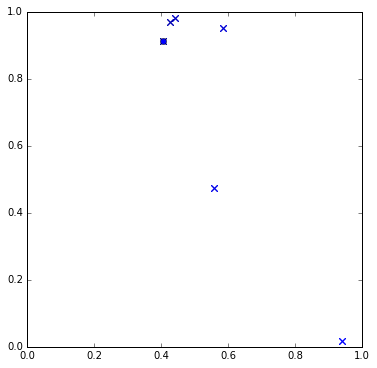

In [25]:
col=['m','r','y','g','b','c']

training=par_obj.FP.keys()
training=training[0:]#[1:21:2]
tpts=range(1,14)
figure(figsize=(6,6))
color=np.array((0,0,1))
for t in training:
    false_positives=0
    true_positives=0
    false_negatives=0
    for tpt in tpts[1:]:

        false_positives+=np.array(par_obj.FP[t][0][tpt])
        true_positives+=np.array(par_obj.TP[t][0][tpt])
        false_negatives+=np.array(par_obj.FN[t][0][tpt])
        Recall=true_positives/(true_positives+false_negatives)
        Precision = true_positives/(true_positives+false_positives)
        #plot(Precision)

    plot(Recall,Precision,'x-',color =tuple(color))
    axis((0,1,0,1))
    color=color-np.array((0,0,0.075))
    #color[np.where(color>0.8)]=0
'''for t in training:
    for tpt in tpts:
        count+=1
        false_positives=np.array(par_obj.FP[t][0][tpt])
        true_positives=np.array(par_obj.TP[t][0][tpt])
        false_negatives=np.array(par_obj.FN[t][0][tpt])
        Recall=true_positives/(true_positives+false_negatives)
        Precision = true_positives/(true_positives+false_positives)
        #plot(Precision)
        plot(Recall,Precision,col[count%6]+'x-')
        axis((0,1,0,1))'''
plot(Recall,Precision,color =(1,0,0))
plot(Recall[0:1],Precision[0:1],'o')

In [11]:
par_obj.FP.keys()

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

In [37]:
par_obj.saved_ROI

[(0, 49, 59, 108, 363, 0, 0), (13, 396, 252, 56, 63, 0, 0)]

In [1]:
print 5

5


In [48]:
color[ind]=color[ind]+0.2

In [8]:
par_obj.data_store['pts'][fileno][time_pt]

[[156, 330, 14, 1],
 [201, 253, 2, 1],
 [242, 217, 3, 1],
 [263, 319, 7, 1],
 [269, 269, 7, 1],
 [300, 237, 6, 1],
 [303, 404, 18, 1],
 [334, 298, 13, 1],
 [364, 211, 9, 1],
 [377, 163, 13, 1]]

In [17]:
par_obj.data_store['pred_arr'][1][0].keys()

[]

{}

In [5]:
par_obj.tiff_file

In [1]:
par_obj.limit_ratio_size

NameError: name 'par_obj' is not defined

In [10]:
par_obj.tiff_file.pages[0]

In [29]:
par_obj.saved_ROI

[(0, 49, 59, 108, 363, 0, 0),
 (0, 176, 231, 59, 57, 0, 0),
 (0, 201, 169, 67, 54, 0, 0),
 (0, 262, 242, 46, 57, 0, 0),
 (2, 232, 236, 44, 67, 0, 0),
 (2, 234, 110, 72, 72, 0, 0),
 (2, 336, 170, 72, 78, 0, 0),
 (5, 180, 229, 64, 56, 0, 0),
 (5, 205, 171, 49, 54, 0, 0),
 (7, 268, 190, 58, 47, 0, 0),
 (7, 329, 277, 38, 61, 0, 0),
 (10, 344, 159, 63, 60, 0, 0),
 (10, 250, 322, 82, 70, 0, 0),
 (13, 396, 252, 56, 63, 0, 0),
 (14, 254, 318, 68, 67, 0, 0),
 (19, 350, 91, 80, 95, 0, 0),
 (2, 179, 232, 59, 53, 0, 0),
 (5, 301, 152, 43, 52, 0, 0),
 (7, 288, 291, 39, 53, 0, 0),
 (9, 366, 261, 46, 52, 0, 0),
 (12, 117, 353, 64, 57, 0, 0),
 (12, 367, 271, 43, 49, 0, 0),
 (17, 280, 55, 67, 71, 0, 0)]

In [33]:
idx

13

In [3]:
par_obj.time_pt_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
par_obj.height

512

In [7]:
par_obj.max_zslices

20

In [9]:
par_obj.data_store['feat_arr'][imno]

{0: {0: array([[[ 0.05490196,  0.01960785,  0.01960785, ...,  0.00724041,
            0.00290676,  0.03893593],
          [ 0.07450981, -0.05490196,  0.02385397, ...,  0.00738499,
            0.00288713,  0.03892199],
          [ 0.0627451 , -0.00784314,  0.01531422, ...,  0.00752957,
            0.0028675 ,  0.03890805],
          ..., 
          [ 0.06666667, -0.01568628,  0.01315334, ...,  0.00754502,
            0.0028654 ,  0.03890952],
          [ 0.07058824, -0.03921569,  0.02047119, ...,  0.00739954,
            0.00288471,  0.03891892],
          [ 0.05490196,  0.01176471,  0.01616905, ...,  0.00725406,
            0.00290401,  0.03892831]],
  
         [[ 0.05490196, -0.00784314,  0.00438445, ...,  0.00738231,
            0.00288864,  0.03894639],
          [ 0.05098039,  0.02745098,  0.01192699, ...,  0.00746809,
            0.00289187,  0.03893215],
          [ 0.05098039,  0.01960785,  0.00706971, ...,  0.00755386,
            0.0028951 ,  0.03891792],
          ..., 
    

In [20]:
par_obj.data_store['pred_arr'][1]


{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {}}